In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
# MinMaxScaler用於數據的歸一化
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據

def create_timestamp(data):
    # 將"Date"和"Time"合併成時間戳記並設置為索引
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    data = data.set_index('Timestamp')
    return data

data_path = r'C:\Users\rex\Desktop\水位預測\3\1510H071.csv'   
data = pd.read_csv(data_path)

# 使用函數創建時間戳
data = create_timestamp(data)
print (data)
data.head(5)



                           Date   Time  1510H071 Water Level  19606 Rainfall
Timestamp                                                                   
2020-01-01 00:00:00    2020/1/1  00:00                 20.58        0.000000
2020-01-01 01:00:00    2020/1/1  01:00                 20.80        0.000000
2020-01-01 02:00:00    2020/1/1  02:00                 20.81        0.000000
2020-01-01 03:00:00    2020/1/1  03:00                 20.80        0.000000
2020-01-01 04:00:00    2020/1/1  04:00                 20.79        0.000000
...                         ...    ...                   ...             ...
2022-12-31 19:00:00  2022/12/31  19:00                 19.22        0.000000
2022-12-31 20:00:00  2022/12/31  20:00                 19.22        0.065994
2022-12-31 21:00:00  2022/12/31  21:00                 19.21        0.057345
2022-12-31 22:00:00  2022/12/31  22:00                 19.21        0.000000
2022-12-31 23:00:00  2022/12/31  23:00                 19.21        0.065994

,Date,Time,1510H071 Water Level,19606 Rainfall
Timestamp,,,,
2020-01-01 00:00:00,2020/1/1,00:00,20.58,0.0
2020-01-01 01:00:00,2020/1/1,01:00,20.80,0.0
2020-01-01 02:00:00,2020/1/1,02:00,20.81,0.0
2020-01-01 03:00:00,2020/1/1,03:00,20.80,0.0
2020-01-01 04:00:00,2020/1/1,04:00,20.79,0.0


In [25]:
data['1510H071 Water Level'] = data['1510H071 Water Level'].round(1)

# 列出所有要增加特徵的欄位名稱
columns_to_expand = [
    # "1510H084 Water Level",
    # "1510H076 Water Level",
    "1510H071 Water Level",
    # "1510H057 Water Level",
    # "19774 Rainfall"
    # "20016 Rainfall",
    "19606 Rainfall"
    # "19335 Rainfall"
]

# 增加_T-1到_T-48的特徵
for col in columns_to_expand:
    for t in range(1, 73):
        new_col_name = f"{col}_T-{t}"
        data[new_col_name] = data[col].shift(t)
# 建立滑動窗口的平均水位和標準差
window_size = 48 # 48小時

# for station in ["1510H084", "1510H076", "1510H071", "1510H057"]:


for station in ["1510H071"]:    
    col = f"{station} Water Level"
    data[f"{col}_rolling_mean"] = data[col].rolling(window_size).mean()     #過去48小時平均水位
    data[f"{col}_rolling_std"] = data[col].rolling(window_size).std()       #過去48小時水位標準差


# data.to_excel(r'C:\Users\rex\Desktop\水位預測\2\總資料新增特徵.xlsx', index=False)

# 對每個站點的水位差分
# for station in ["1510H084", "1510H076", "1510H071", "1510H057"]:

for station in ["1510H071"]:    
    col = f"{station} Water Level"
    data[f"{col}_diff"] = data[col].diff()                                  #前一小時水位差


data

,Date,Time,1510H071 Water Level,19606 Rainfall,1510H071 Water Level_T-1,1510H071 Water Level_T-2,1510H071 Water Level_T-3,1510H071 Water Level_T-4,1510H071 Water Level_T-5,1510H071 Water Level_T-6,...,19606 Rainfall_T-66,19606 Rainfall_T-67,19606 Rainfall_T-68,19606 Rainfall_T-69,19606 Rainfall_T-70,19606 Rainfall_T-71,19606 Rainfall_T-72,1510H071 Water Level_rolling_mean,1510H071 Water Level_rolling_std,1510H071 Water Level_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020/1/1,00:00,20.6,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,2020/1/1,01:00,20.8,0.000000,20.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2020-01-01 02:00:00,2020/1/1,02:00,20.8,0.000000,20.8,20.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-01 03:00:00,2020/1/1,03:00,20.8,0.000000,20.8,20.8,20.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-01 04:00:00,2020/1/1,04:00,20.8,0.000000,20.8,20.8,20.8,20.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022/12/31,19:00,19.2,0.000000,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0
2022-12-31 20:00:00,2022/12/31,20:00,19.2,0.065994,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0
2022-12-31 21:00:00,2022/12/31,21:00,19.2,0.057345,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0


In [26]:
    # 增加T+1到T+48的雨量
    for station in [
        # "19774 Rainfall"
        # "20016 Rainfall",
        # "19335 Rainfall"
        "19606 Rainfall"
        ]:
        col = f"{station}"
        for t in range(1, 73):
            future_col_name = f"{col}_T+{t}"
            data[future_col_name] = data[col].shift(-t)

    # 刪除包含NaN的行
    data = data.dropna()
    # 刪除不必要的列
    data = data.drop(['Date', 'Time'], axis=1)  


In [27]:
# 列出目標水位列
target_columns = [
    # "1510H057 Water Level"
    "1510H071 Water Level"
    # "1510H076 Water Level",
    # "1510H084 Water Level"
]
# 1. 增加目標列：T+1到T+48的目標水位
for target_col in target_columns:
    for t in range(1, 289):
        target = f'{target_col}_target_{t}'
        data[target] = data[target_col].shift(-t)
        
# 移除含有 NaN 的行
data = data.dropna()


In [28]:
# 歸一化數據 X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 最小最大歸一化
scalers = {}
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    s_s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    data[i] = s_s

In [29]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.layers import TimeDistributed, Flatten
from lightgbm import early_stopping


In [30]:
#定義滑動窗口，窗口由 time_steps 參數控制
def create_dataset(X, y, time_steps=1):         #   X 和 y，分別代表特徵和目標變量。time_steps 參數則表示滑動窗口的大小。
    Xs, ys = [], []                             #   創建兩個空的列表 Xs 和 ys
    for i in range(len(X) - time_steps):        #從第一個時間點開始，一直到可以形成最後一個完整的滑動窗口的位置。
        v = X.iloc[i:(i + time_steps)].values   #選取一個時間窗口內的數據。第 i 時間點開始，包含了接下來的 time_steps 個時間點的數據。
        Xs.append(v)                            #將這個時間窗口的數據添加到 Xs 列表中。
        ys.append(y.iloc[i + time_steps])       #將目標變量在該窗口之後的第一個值添加到 ys 列表中。這個值是與前面時間窗口的 X 對應的 y。
    return np.array(Xs), np.array(ys)           #將 Xs 和 ys 轉換為 numpy 數組並返回。

In [31]:
# MAPE計算函數
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
import random
from joblib import dump
#隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 切分數據集，前80%的數據作為訓練集，剩下的20%作為測試集。
train_size = int((len(data) *0.8))
train_data = data[:train_size]
test_data = data[train_size:]

#然後將訓練集中最後的10%作為驗證集。
val_size = int(len(train_data) *0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

#定義時間步長
time_steps = 48

#副本的創建
train_temp = train_data.copy()
val_temp = val_data.copy()
test_temp = test_data.copy()


Size of data_temp_loop: 49
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_1, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_2, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_3, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_4, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_5, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_6, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_7, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_8, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_9, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_10, X_test is empty!
Timestamp: 2022-12-16 23:00:00, Target: 1510H071 Water Level_target_11, X_test is empty!
Tim

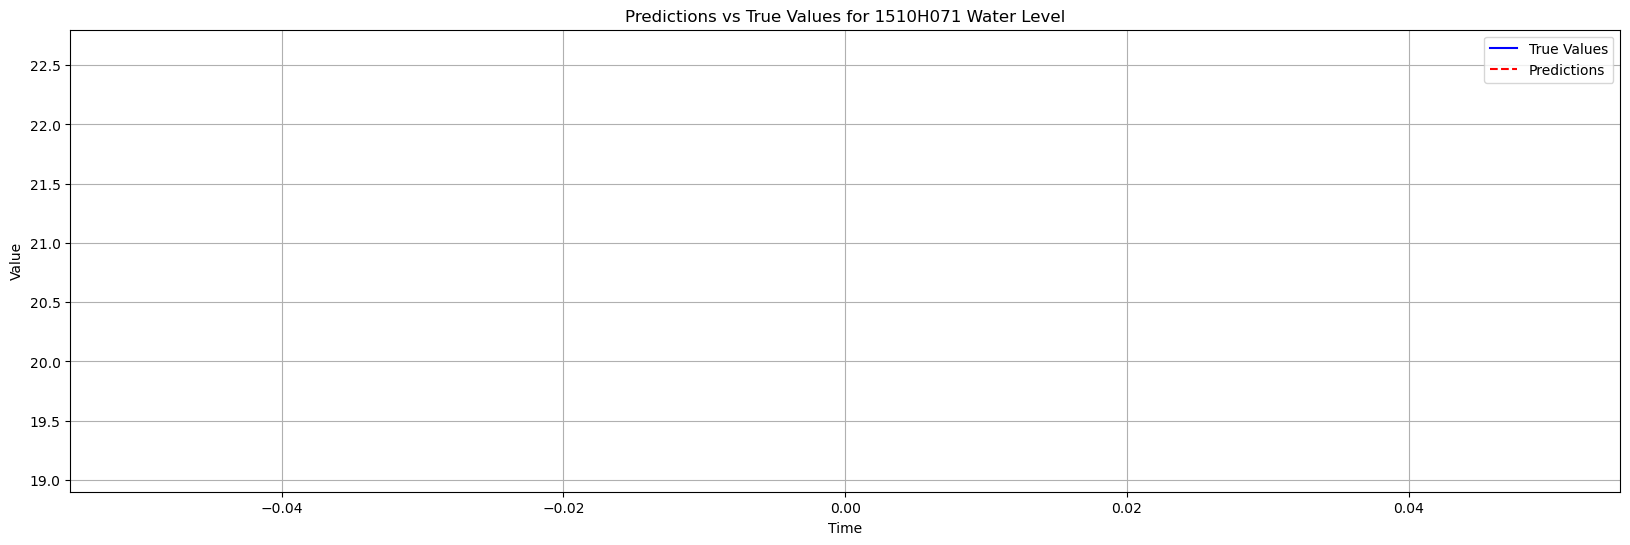

In [33]:
import datetime
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


specified_timestamp = "2022-12-16 23:00:00"
specified_timestamp_dt = datetime.datetime.strptime(specified_timestamp, '%Y-%m-%d %H:%M:%S')

data_temp = data.loc[specified_timestamp_dt - datetime.timedelta(hours=24): 
                     specified_timestamp_dt + datetime.timedelta(hours=47)]

global_ymin = data[target_columns].min().min()
global_ymax = data[target_columns].max().max()
print(f"Size of data_temp_loop: {len(data_temp_loop)}")

for target_col in target_columns:
    data_temp_loop = data_temp.copy()  # 這裡創建了data_temp的一個副本，使其在每次迴圈中保持原始狀態


    # 在進行預測之前，將這些數據值轉換回原始尺度
    global_ymin_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymin]])[0][0]
    global_ymax_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymax]])[0][0]
    
    true_values = []
    predictions = []    
    
    for t in range(1, 289):

        # 載入模型
        model = load(f"water_model4/model_{target_col}_t{t}.joblib")

        # 如果t不等於1，更新test_temp中的特定列值為上一個時刻的預測值
        if t > 1 and predictions:
            # 將 T+1 的預測值設置為 T+2 的輸入
            data_temp_loop.loc[specified_timestamp_dt, target_col] = predictions[-1]
        
        target = f"{target_col}_target_{t}"

        # 切分測試集
        X_test, y_test = create_dataset(data_temp_loop.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), data_temp_loop[target], time_steps)
        if len(X_test) == 0:
            print(f"Timestamp: {specified_timestamp}, Target: {target}, X_test is empty!")
            continue  # 如果X_test為空，則跳過後續的代碼並進行下一次迴圈        
        # 重塑 X_test
        X_test = X_test.reshape((X_test.shape[0], -1))
        
        # 進行預測
        y_pred = model.predict(X_test)
        y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        true_values.append(y_test_rescaled[-1])  # 取最後一個真實值
        predictions.append(y_pred_rescaled[-1])  # 取最後一個預測值
        
        r2 = r2_score(y_test_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
        
        # timestamp 為測試數據集中的預測開始的時間點
        print(f"Timestamp: {specified_timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
        
    # 繪製真實值與預測值
    plt.figure(figsize=(20, 6))
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    
    # 使用轉換回原始尺度的最大和最小值設置y軸尺度
    plt.ylim(global_ymin_rescaled, global_ymax_rescaled)
    
    plt.title(f"Predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()